In [26]:
!pip install tensorflow

# import libraries

In [78]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Concatenate



# Download the MovieLens 100k dataset


In [28]:
# !wget http://files.grouplens.org/datasets/movielens/ml-100k.zip
# !unzip ml-100k.zip

--2025-01-05 17:20:21--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip.1’

ml-100k.zip.1       100%[===================>]   4.70M  11.7MB/s    in 0.4s    

2025-01-05 17:20:22 (11.7 MB/s) - ‘ml-100k.zip.1’ saved [4924029/4924029]

Archive:  ml-100k.zip
replace ml-100k/allbut.pl? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Read the ratings data


In [79]:
ratings = pd.read_csv(
    'ml-100k/u.data',
    sep='\t',
    header=None,
    names=['user_id', 'item_id', 'rating', 'timestamp']
)

# Drop the timestamp column


In [80]:
ratings.drop('timestamp', axis=1, inplace=True)

# Encode user_id and item_id as numeric values


In [81]:
le = LabelEncoder()
ratings['user_id'] = le.fit_transform(ratings['user_id'])
ratings['item_id'] = le.fit_transform(ratings['item_id'])

# Split the data into training and testing sets


In [82]:
train_data, test_data = train_test_split(ratings, test_size=0.2)

# Display dataset statistics


In [83]:
user_ids = ratings['user_id'].unique()
movie_ids = ratings['item_id'].unique()
ratings_range = ratings['rating'].agg(['min', 'max'])

print(f"Number of users: {len(user_ids)}, Number of Movies: {len(movie_ids)}, Min rating: {ratings_range['min']}, Max rating: {ratings_range['max']}")


Number of users: 943, Number of Movies: 1682, Min rating: 1, Max rating: 5


# Define input layers for user and item IDs


In [84]:
embedding_size = 64

user_id_input = Input(shape=[1], name='user')
item_id_input = Input(shape=[1], name='item')

# Define embedding layers for users and items


In [61]:
# user_embedding_layer = Embedding(
#     output_dim=embedding_size,
#     input_dim=len(user_ids),
#     input_length=1,
#     name='user_embedding'
# )
# item_embedding_layer = Embedding(
#     output_dim=embedding_size,
#     input_dim=len(movie_ids),
#     input_length=1,
#     name='item_embedding'
# )


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [85]:
user_embedding_layer = Embedding(
    output_dim=embedding_size,
    input_dim=len(user_ids),
    input_length=1,
    name='user_embedding',
    embeddings_initializer='he_normal'
)

item_embedding_layer = Embedding(
    output_dim=embedding_size,
    input_dim=len(movie_ids),
    input_length=1,
    name='item_embedding',
    embeddings_initializer='he_normal'
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


# Apply embedding layers and flatten the outputs


In [86]:
user_embedding = user_embedding_layer(user_id_input)
item_embedding = item_embedding_layer(item_id_input)
user_vecs = Flatten()(user_embedding)
item_vecs = Flatten()(item_embedding)

# Compute dot product for user-item interaction


In [47]:
# interaction = Dot(1, normalize=False)([user_vecs, item_vecs])

In [87]:
interaction = Dot(axes=1, normalize=False)([user_vecs, item_vecs])
hidden = Dense(64, activation='relu')(interaction)
output = Dense(1)(hidden)

# model = Model(inputs=[user_id_input, item_id_input], outputs=output)
# model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')


# Define the model


In [88]:
model = Model(inputs=[user_id_input, item_id_input], outputs=interaction)
# model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

# Train the model

In [89]:
history = model.fit(
    [train_data['user_id'], train_data['item_id']],
    train_data['rating'],
    batch_size=64,
    epochs=5,
    validation_split=0.1
)


Epoch 1/5
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 13.0886 - mae: 3.4276 - val_loss: 2.8956 - val_mae: 1.3859
Epoch 2/5
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.9070 - mae: 1.0857 - val_loss: 1.0613 - val_mae: 0.8101
Epoch 3/5
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.9748 - mae: 0.7744 - val_loss: 0.9485 - val_mae: 0.7656
Epoch 4/5
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.8541 - mae: 0.7275 - val_loss: 0.9176 - val_mae: 0.7552
Epoch 5/5
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.7898 - mae: 0.6998 - val_loss: 0.8969 - val_mae: 0.7481


# Plot training and validation losses


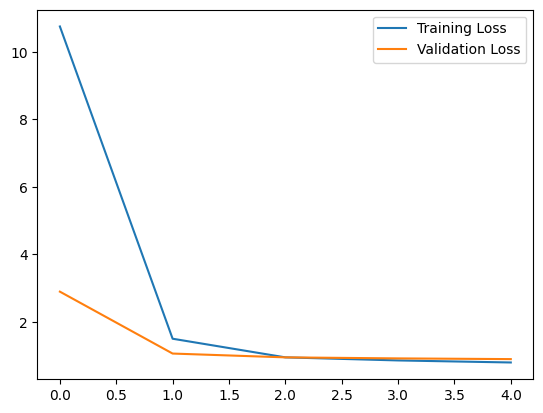

In [90]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


# Calculate recall

In [100]:
def recall(model, test_data, train_data, k=10):
    recalls = []

    for user_id in test_data['user_id'].unique():
        user_movies_test = test_data[test_data['user_id'] == user_id]['item_id'].values
        user_movies_train = train_data[train_data['user_id'] == user_id]['item_id'].values
        user_movies_all = set(user_movies_test) | set(user_movies_train)

        if len(user_movies_test) == 0:
            continue

        user_ids = [user_id] * len(movie_ids)
        item_ids = range(len(movie_ids))
        predictions = model.predict([tf.constant(user_ids), tf.constant(item_ids)])
        predicted_ratings = predictions.flatten()

        top_k_indices = predicted_ratings.argsort()[-k:][::-1]
        # top_k_movies = [movie_id for movie_id in top_k_indices if movie_id not in user_movies_all][:k]
        top_k_movies = [movie_id for movie_id in top_k_indices if movie_id in user_movies_test][:k]
        true_positives = sum([1 for movie_id in top_k_movies if movie_id in user_movies_test])
        recall = true_positives / len(user_movies_test)
        recalls.append(recall)

    mean_recall = sum(recalls) / len(recalls) if len(recalls) > 0 else 0
    return mean_recall


In [101]:
recall_at_10 = recall(model, test_data, train_data)
print(f'Mean Recall@10 on test data: {recall_at_10:.4f}')

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━

In [102]:
train_movies = set(train_data['item_id'])
test_movies = set(test_data['item_id'])

unseen_movies = test_movies - train_movies
print(f"Movies in test set but not in training set: {unseen_movies}")


Movies in test set but not in training set: {1664, 1665, 1667, 1413, 1550, 1560, 1561, 1562, 1308, 1564, 1570, 813, 1582, 1583, 1585, 1586, 1338, 829, 710, 1481, 1485, 1234, 1365, 1493, 856, 1497, 1514, 1646, 1652, 1654, 1531, 1532}


Recommend movies

In [103]:
def debug_predictions(model, user_id, train_data, test_data, movie_ids, k=10):
    user_movies_test = test_data[test_data['user_id'] == user_id]['item_id'].values

    all_movie_ids = range(len(movie_ids))
    user_ids = [user_id] * len(movie_ids)
    predictions = model.predict([tf.constant(user_ids), tf.constant(all_movie_ids)])
    predicted_ratings = predictions.flatten()

    top_k_indices = predicted_ratings.argsort()[-k:][::-1]
    top_k_movies = [movie_ids[i] for i in top_k_indices if i < len(movie_ids)]

    print(f"User ID: {user_id}")
    print(f"Movies seen by user (test): {user_movies_test}")
    print(f"Top-{k} movies recommended: {top_k_movies}")
    print(f"Intersecting movies: {set(user_movies_test).intersection(set(top_k_movies))}")


In [105]:
all_movie_ids = range(len(movie_ids))
user_ids = [user_id] * len(movie_ids)
predictions = model.predict([tf.constant(user_ids), tf.constant(all_movie_ids)])
predicted_ratings = predictions.flatten()

print(f"Predicted ratings for user {user_id}: {predicted_ratings}")


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Predicted ratings for user 42: [3.8514254 3.2006586 2.8657336 ... 1.3209244 1.4398004 1.8480127]


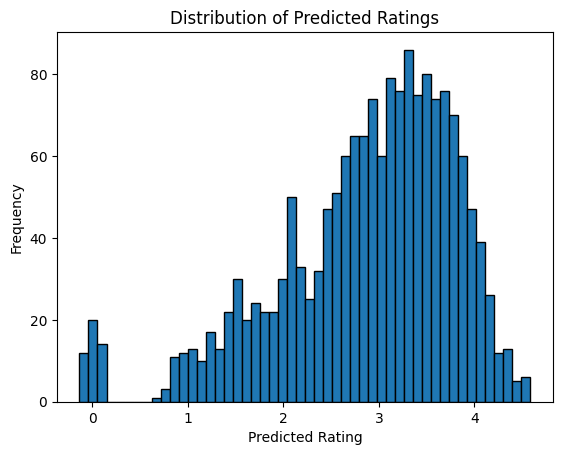

In [106]:
import matplotlib.pyplot as plt

plt.hist(predicted_ratings, bins=50, edgecolor='k')
plt.title("Distribution of Predicted Ratings")
plt.xlabel("Predicted Rating")
plt.ylabel("Frequency")
plt.show()


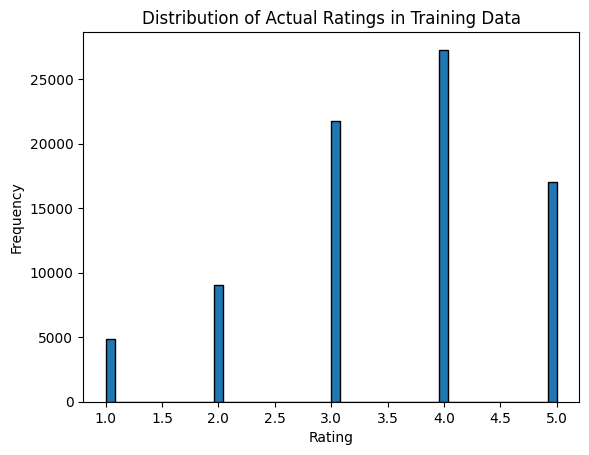

In [107]:
plt.hist(train_data['rating'], bins=50, edgecolor='k')
plt.title("Distribution of Actual Ratings in Training Data")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()


In [108]:
def recommend_movies(model, user_id, k=10):
    user_movies = test_data[test_data['user_id'] == user_id]['item_id'].values

    all_movie_ids = range(len(movie_ids))
    user_ids = [user_id] * len(movie_ids)
    predictions = model.predict([tf.constant(user_ids), tf.constant(all_movie_ids)])
    predicted_ratings = predictions.flatten()

    top_k_indices = predicted_ratings.argsort()[-k:][::-1]
    recommended_movies = [movie_id for movie_id in top_k_indices if movie_id not in user_movies][:k]

    return recommended_movies

# Example: Recommend movies for a specific user

In [109]:
user_id = 4
recommended_movies = recommend_movies(model, user_id)
print(f'Recommended movies for user {user_id}: {recommended_movies}')

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Recommended movies for user 4: [407, 168, 602, 11, 188, 63, 1006, 113]


In [110]:
user_id = 4  # Example user
predictions = model.predict([tf.constant([user_id] * len(movie_ids)), tf.constant(range(len(movie_ids)))])
print(predictions.flatten())

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[3.3205745 2.6314242 2.5020733 ... 1.040909  1.2470791 1.606655 ]
